<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI_4962_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Oct 23 03:18:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Task 1
I used [pytorch](https://pytorch.org/) framework.

In pytorch, tensor computation history is automaticly tracted by
`torch.autograd`, and it is enabled by default for `torch.tensor`. As a result, we just need to focus on forward propagation, which is also the network building process. The backward propagation will be calculated by the impliment of pytorch via `Tensor.backward()`.
- `torch.nn` provides almost everything relates to the neural network, including activation functions, linear layers, and loss functions. We will use `torch.nn` heavily to build our NN.
- `torch.nn.Sequential` is used to connect different layers (automaticly pass layer`i`'s output to layer`i+1`'s input).
- `torch.optim` contains all the optimizers we need to train our network.

#### Resource I used:
- https://pytorch.org/docs/stable/nn.html
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://pytorch.org/docs/stable/autograd.html
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
!curl -o dataset.csv https://raw.githubusercontent.com/kalilurrahman/MasterCardStockData/main/Mastercard_stock_history.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  380k  100  380k    0     0  1224k      0 --:--:-- --:--:-- --:--:-- 1224k


In [4]:
raw_dataset = pd.read_csv("dataset.csv", index_col="Date", parse_dates=["Date"]) \
    .drop(["Dividends", "Stock Splits"], axis=1)

print('data sample', raw_dataset.head(), sep='\n', end='\n\n\n')

print('raw_dataset.info()')
raw_dataset.info()
print(end='\n\n')

print('raw_dataset.describe()', raw_dataset.describe(), sep='\n')

data sample
                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


raw_dataset.info()
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3872 entries, 2006-05-25 to 2021-10-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3872 non-null   float64
 1   High    3872 non-null   float64
 2   Low     3872 non-null   float64
 3   Close   3872 non-null   float64
 4   Volume  3872 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 181.5 KB


raw_dataset.describe()
              Open         High          Low        Close        Volume
c

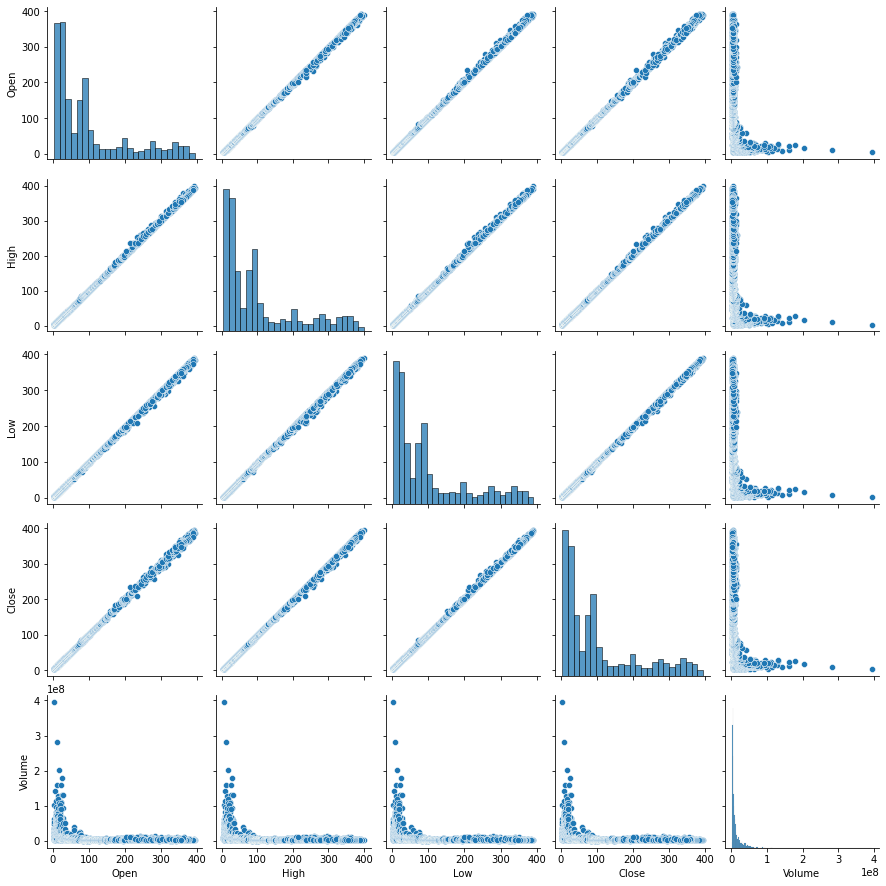

In [ ]:
sns.pairplot(data=raw_dataset)

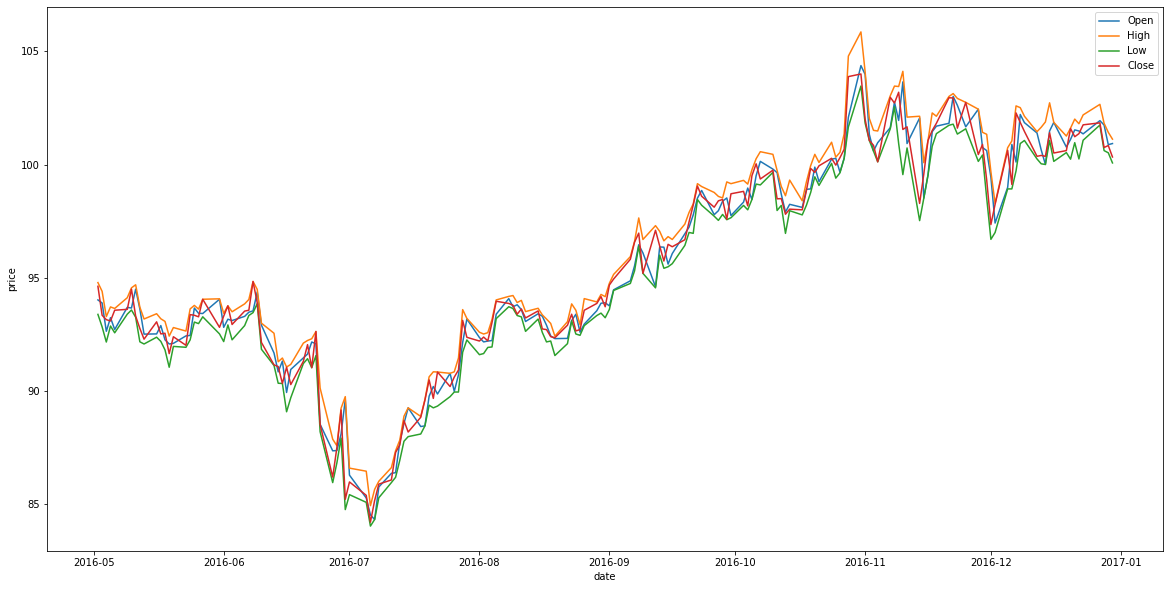

In [17]:
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

plt.rcParams["figure.figsize"] = (20,10)

start_date = '2016-05'
end_date = '2016'

dopen = raw_dataset.loc[start_date:end_date, 'Open']
dhigh = raw_dataset.loc[start_date:end_date, 'High']
dlow = raw_dataset.loc[start_date:end_date, 'Low']
dclose = raw_dataset.loc[start_date:end_date, 'Close']
plt.plot(dopen, label="Open")
plt.plot(dhigh, label="High")
plt.plot(dlow, label="Low")
plt.plot(dclose, label="Close")

plt.xlabel('date')
plt.ylabel('price')

plt.legend()

In [ ]:
start_date = '2016-05'
end_date = '2016'
dhigh = raw_dataset.loc[start_date:end_date, 'High']

In [30]:
class ArrayDataset(Dataset):
  def __init__(self, data, input_len=10, transform=None, target_transform=None):
    self.data = data
    self.input_len = input_len
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.data) - self.input_len - 1

  def __getitem__(self, idx):
    idx = idx
    x = self.data[-idx-1-self.input_len : -idx-1]
    y = self.data[-idx-1]
    return torch.tensor(x, dtype=torch.float32).reshape(-1, 1), \
        torch.tensor([y], dtype=torch.float32)

In [6]:
full_dataset = ArrayDataset(raw_dataset['High'].values, input_len=30)
def partition_dataset(dataset):
  partition_plan = np.round(np.array([0.7, 0.2, 0.1]) * len(dataset)).astype(np.int32)
  partition_plan[2] = len(dataset) - np.sum(partition_plan[:2])
  trainset, valset, testset = random_split(
      dataset, partition_plan,
      generator=torch.Generator().manual_seed(0)
    )
  return trainset, valset, testset

trainset, valset, testset = partition_dataset(full_dataset)
print(f'len(full_dataset) = {len(full_dataset)}')
print(f'len(trainset) = {len(trainset)}')
print(f'len(valset) = {len(valset)}')
print(f'len(testset) = {len(testset)}')

len(full_dataset) = 3841
len(trainset) = 2689
len(valset) = 768
len(testset) = 384


In [12]:
class LstmNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,hidden_size=300,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(300, 1)
    
  def forward(self, x):
    out, _ = self.lstm(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

class RNNNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.rnn = nn.RNN(input_size=1,hidden_size=300,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(300, 1)
    
  def forward(self, x):
    out, _ = self.rnn(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

class GRUNetwork(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.gru = nn.GRU(input_size=1,hidden_size=300,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(300, 1)
    
  def forward(self, x):
    out, _ = self.gru(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

class LstmNetwork2(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.lstm = nn.LSTM(input_size=1,hidden_size=500,
                dropout=0, batch_first=True)
    self.fc1 = nn.Linear(500, 1)
    
  def forward(self, x):
    out, _ = self.lstm(x)
    out2 = torch.tanh(out[:, -1, :])
    out3 = self.fc1(out2)
    return out3

In [8]:
device = torch.device('cuda:0')

In [9]:
model = LstmNetwork().to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), \
      lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)

In [37]:
@torch.no_grad()
def val(m, loss_fn, valloader):
  loss_list = []
  for x, y in valloader:
    x = x.to(device)
    y = y.to(device)
    y_pred = m(x)
    loss = loss_fn(y_pred, y)
    loss_list.append(loss.item())
  return sum(loss_list) / len(loss_list)

def train(epoch, m, loss_fn, optimizer, trainloader, valloader=None):
  pbar = tqdm(range(epoch))
  loss_list = []
  val_loss_list = []
  val_loss = 0.
  for i in pbar:
    sub_loss_list = []
    for x, y in trainloader:
      x = x.to(device)
      y = y.to(device)
      y_pred = m(x)

      optimizer.zero_grad()
      loss = loss_fn(y_pred, y)
      loss_num = loss.item()
      sub_loss_list.append(loss_num)
      pbar.set_description(f'val_loss={val_loss:.4} loss={loss_num:.4}') 

      loss.backward()
      optimizer.step()
    
    epoch_loss = sum(sub_loss_list) / len(sub_loss_list)
    loss_list.append(epoch_loss)

    if valloader is not None:
      val_loss = val(m, loss_fn, valloader)
      pbar.set_description(f'val_loss={val_loss:.4} loss={loss_num:.4}') 
      val_loss_list.append(val_loss)

  return loss_list, val_loss_list

  0%|          | 0/500 [00:00<?, ?it/s]

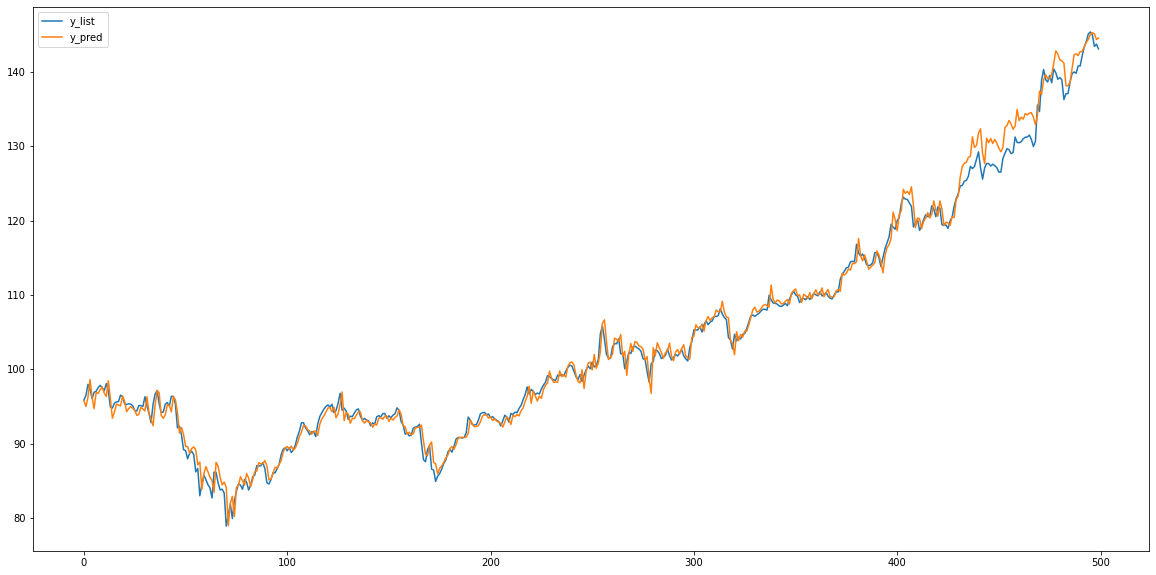

In [40]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=20)
trainset, valset, testset = partition_dataset(dataset)
model = LstmNetwork().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.02, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

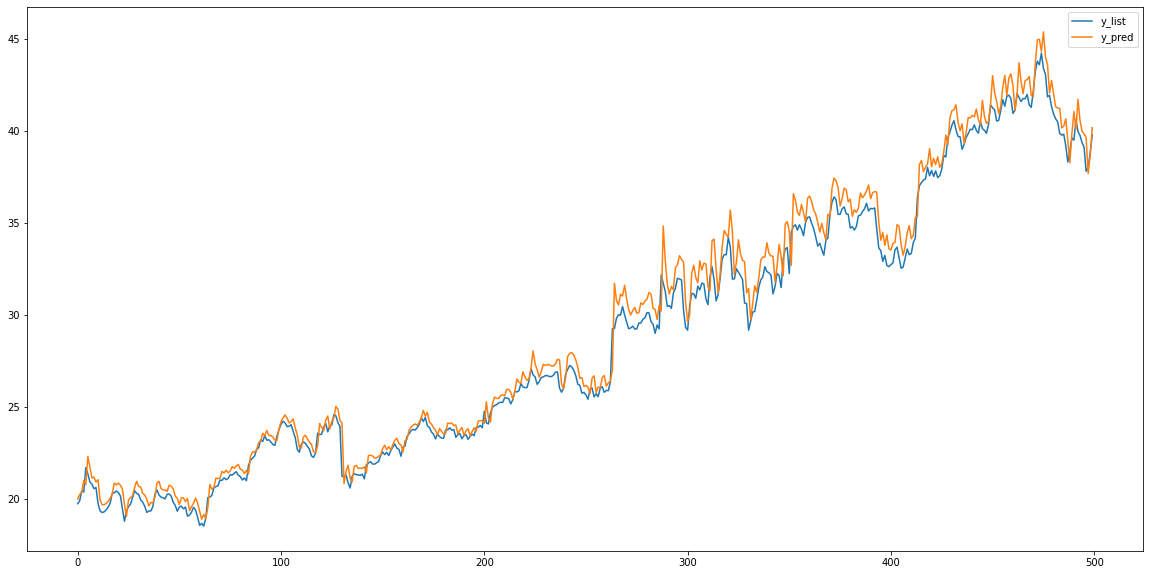

In [20]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=20)
model = RNNNetwork().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500):
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

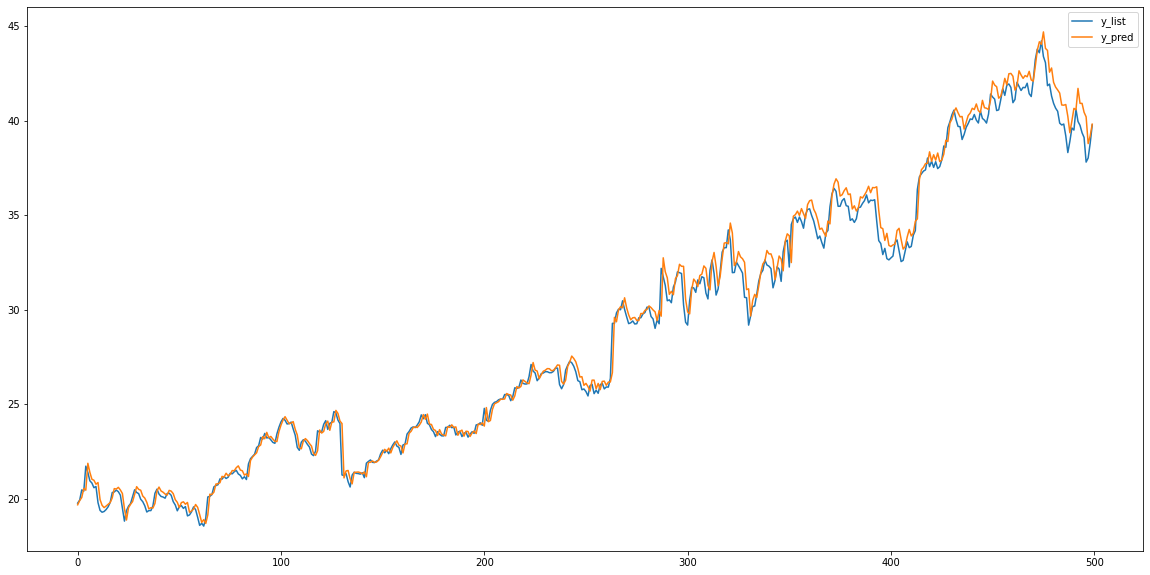

In [24]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=20)
model = GRUNetwork().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500):
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

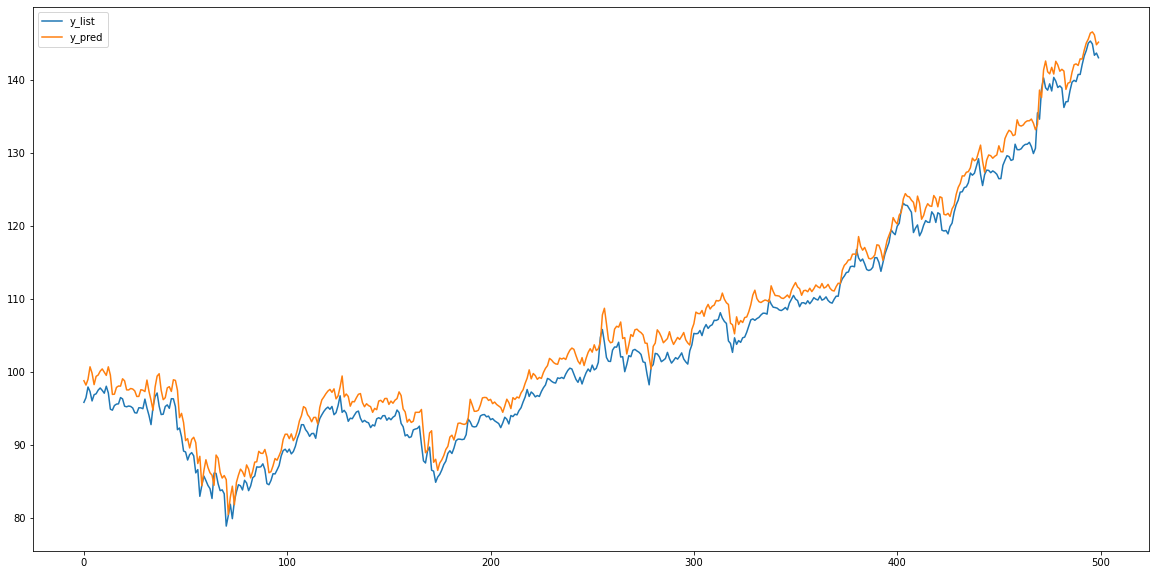

In [46]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=80)
trainset, valset, testset = partition_dataset(dataset)
model = LstmNetwork2().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(trainset, batch_size=len(trainset), shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

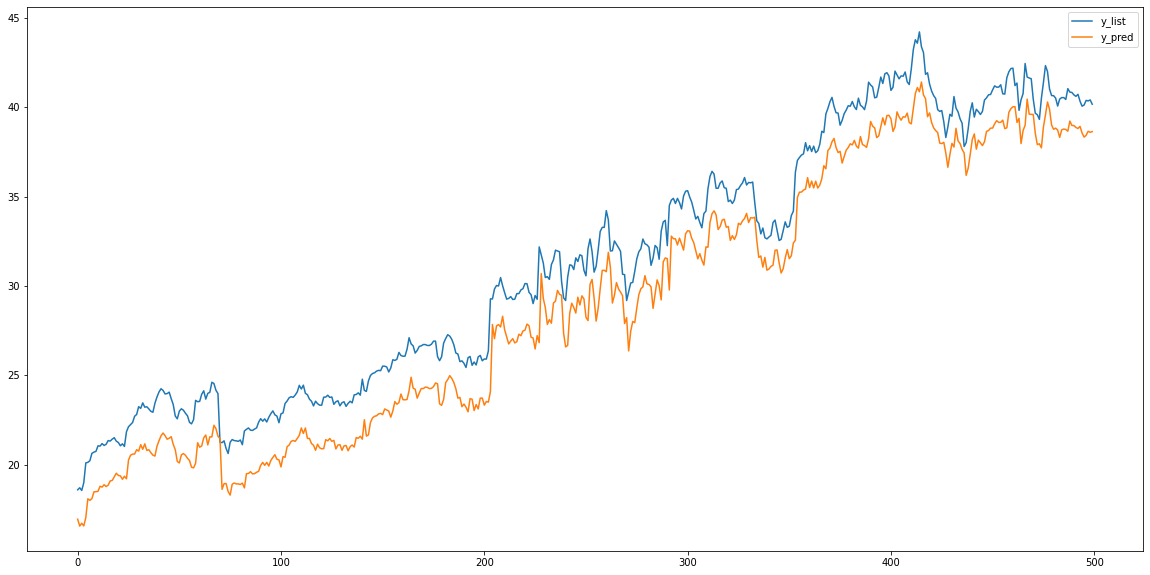

In [25]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=80)
model = LstmNetwork().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset)//4, shuffle=True)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500):
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

  0%|          | 0/500 [00:00<?, ?it/s]

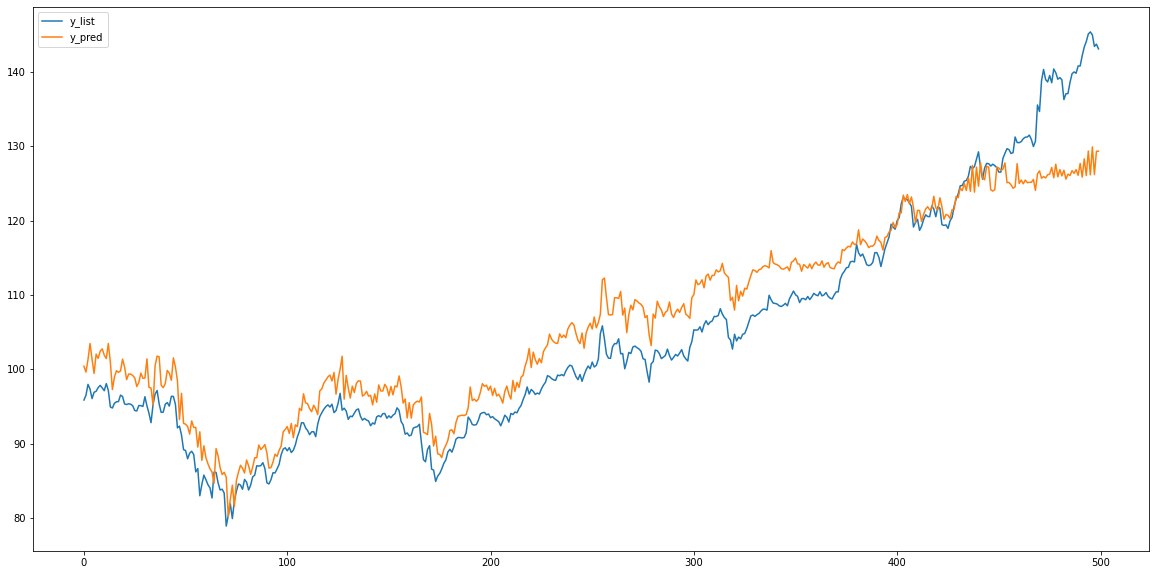

In [45]:
dataset = ArrayDataset(raw_dataset['High'].values, input_len=20)
trainset, valset, testset = partition_dataset(dataset)
model = LstmNetwork2().to(device)
loss_fn = nn.MSELoss()
# optimizer = optim.RMSprop(model.parameters(), \
#       lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
dataloader = DataLoader(dataset, batch_size=len(dataset)//4, shuffle=True)
valloader = DataLoader(valset, batch_size=len(valset), shuffle=False)
loss_list, _ = train(500, model, loss_fn, optimizer, dataloader, valloader)

y_list = []
y_pred_list = []
for i in range(1000, 1500)[::-1]:
  x, y = dataset[i]
  x= x.to(device).reshape(1, -1, 1)
  y_list.append(y.item())
  y_pred = model(x)
  y_pred_list.append(y_pred.item())

plt.plot(y_list, label='y_list')
plt.plot(y_pred_list, label='y_pred')
plt.legend()

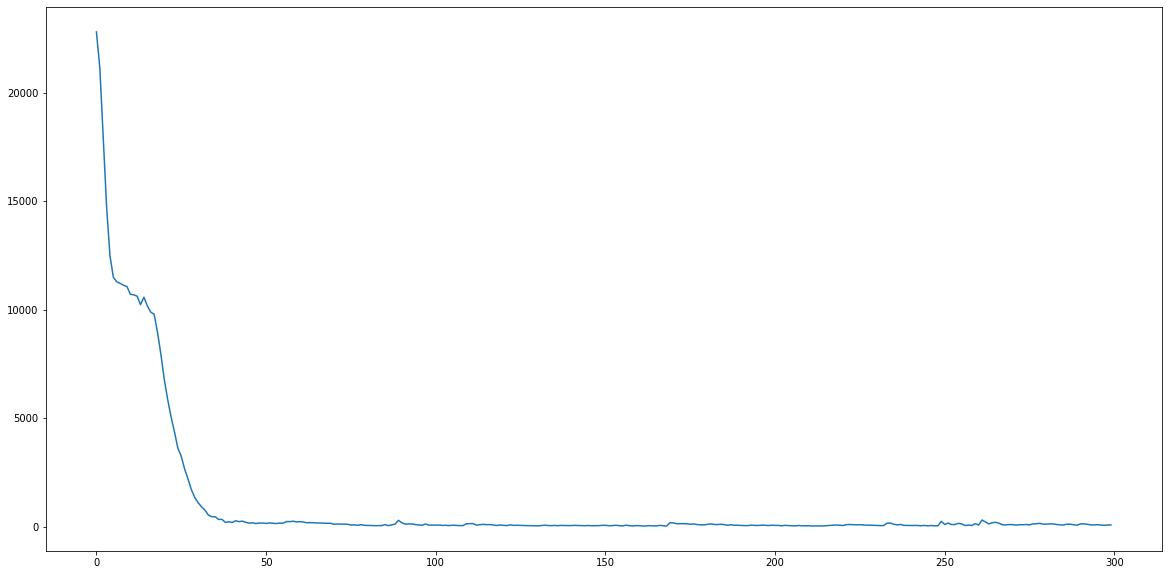

In [106]:
plt.plot(loss_list)

# Task 2
The CIFAR-10 dataset contains 60000 images with a resolution of 3x32x32(RGB·W·H) in 10 classes. The dataset is balanced, with 6000 images per class. In addition, this dataset is a clean datatset.
As mentioned in previous homework, the EDA we can do for graphic input is limited since every pixel is independent.